В этом проекте будет решаться задача идентификации пользователя по его поведению в сети Интернет. В качестве примера, это может потребоваться для идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду.

Шаги проекта:
* цели и задачи проекта, описание исходных и обработанных данных и признаков.
* первичный анализ признаков
* первичный визуальный анализ признаков
* если пришли к каким-то "инсайтам", обнаружили закономерности – изложите
* описание предобработки данных
* если создаются признаки, то описание этого процесса
* кросс-валидация, построение кривых валидации и обучения
* оценка модели с описанием выбранной метрики. Опишите простыми словами качество модели, как она может применяться
* выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.


Здесь будет решена другая задача: по последовательности из нескольких веб-сайтов, посещенных подряд одим и тем же человеком, будет идентифицироваться этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

Будем использовать данные из статьи "A Tool for Classification of Sequential Data". Для каждого пользователя заведен csv-файл с названием user****.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате:

*timestamp, посещенный веб-сайт*

Мы столкнемся с проблемой, что не все операции можно выполнить за разумное время, поэтому мы будем использовать параллельно 2 выборки: по 10 и по 150 пользователям. На данных по десяти польщователям будет производиться отладка, а по 150 – рабочая версия.

In [29]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import itertools
from time import time
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from math import ceil
from scipy.sparse import csr_matrix
pd.set_option('display.max.columns', 25)
import pickle
from datetime import datetime
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

PATH_TO_DATA = 'capstone_user_identification'

# I Первичный анализ данных

In [33]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10):
    
    list_data = []
    window_size = session_length
    
    search_ids = []
    search_name = ['facebook']         ## ниже реализован алгоритм, который позволяет находить слова, содержащие ключевые слова по СПИСКУ самих этих ключей
    search_name_len = len(search_name)
    
    columns = ['site' + str(i) for i in range(1,session_length + 1)]
    diff_time = ['time_diff' + str(j) for j in range(1,session_length)]

    feature_names = columns + diff_time + ['session_timespan',
                                           '#unique_sites',
                                           'start_hour', 
                                           'day_of_week',
                                           'Average_time_on_top30_sites',
                                           'facebook',
                                           'target']
    
    path_to_each_files = glob(os.path.join(path_to_csv_files,'user*.csv'))
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    
    for search in search_name:
        ids = []
        for site in site_freq:
            if search in site:
                ids += [site_freq[site][0]]
        search_ids += [ids]
    
    top30 = [v[0] for k, v in sorted(site_freq.items(), key=lambda item: item[1][1], reverse=True)][0:10]
    
    for path_to_file in path_to_each_files:
        file = pd.read_csv(path_to_file)
        a = [site_freq[site][0] for site in file['site']]
        tmp_1 = [datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in file['timestamp'].values]
        
        count_of_rows = ceil(len(a) / window_size)
        l = len(a) 
        y = [int(path_to_file[-8:-4])]
    
        for i in range(count_of_rows):
            nulls = session_length - l + i*window_size
            line = a[i*window_size : i*window_size + session_length]
            
            ## Считаем время посещения каждого сайта в сессии
            tmp_2 = tmp_1[i*window_size : i*window_size + session_length]
            time = [(tmp_2[i] - tmp_2[i-1]).total_seconds() for i in range(1,len(line))]
            
            ## Считаем количество посещений важных сайтов за одну сессию
            count_of_search_names = [0] * search_name_len
            for j in range(search_name_len):
                for id_ in line:
                    if id_ in search_ids[j]:
                        count_of_search_names[j] += 1
            
            ## Считаем среднее время посещения сайта из TOP 30 за одну сессию.
            ## Если в сессии не было сайтов из TOP 30, то будем возвращать им значения -1
            count_of_match_with_top = 0
            time_of_top = 0
            for k, id_ in enumerate(line):
                if (id_ in top30) & (k < len(line) - 1):
                    time_of_top += time[k]
                    count_of_match_with_top += 1
            if count_of_match_with_top != 0:
                Average_time_on_top30_sites = time_of_top / count_of_match_with_top
            else:
                Average_time_on_top30_sites = -1
            
            ## Получаем итоговую строчку в датафрейме для одной сессии
            line = (  line + [0]*(nulls)*(nulls > 0)      ## сайты в сессии
                    + time + [0]*(nulls)*(nulls > 0)      ## время между сайтами в сессии
                    + [np.array(time).sum()]              ## время всей сессии
                    + [np.unique(line).shape[0]]          ## количество уникальных сайтов в сессии
                    + [tmp_2[0].hour]                     ## час начала сессии
                    + [tmp_2[0].weekday()]                ## день недели
                    + [Average_time_on_top30_sites]       ## среднее время на сайте из Top 30
                    + [count_of_search_names[0]]          ## количество посещений facebook (всех вариаций ссылок)
                    + y)                                  ## ID пользователя
            
            list_data = list_data + [line]        
    data = pd.DataFrame(list_data, columns = feature_names)
    return data


id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

data_10users = feature_engineering(os.path.join(PATH_TO_DATA,'10users'),
                                           site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           session_length=10)
data_10users['target'] = data_10users['target'].map(id_name_dict)
data_10users.head(5)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,Average_time_on_top30_sites,facebook,target
0,173,3730,3731,17,3731,3731,17,3731,48,3731,10.0,0.0,...,20.0,1.0,0.0,1.0,0.0,33.0,5,8,4,0.5,0,John
1,332,147,196,99,3731,20,3732,3733,352,3734,1.0,0.0,...,0.0,1.0,3.0,3.0,8.0,284.0,10,8,4,-1.0,0,John
2,3734,17,3734,3734,28,197,332,29,1805,3734,0.0,14.0,...,0.0,0.0,1.0,0.0,0.0,258.0,7,8,4,7.0,1,John
3,356,3735,356,3734,3734,3734,3734,141,347,346,2.0,1.0,...,25.0,1.0,0.0,0.0,0.0,30.0,6,8,4,-1.0,0,John
4,193,3734,28,3736,232,185,3737,3738,451,3738,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,6.0,9,8,4,1.0,1,John


# II Визуальный анализ данных

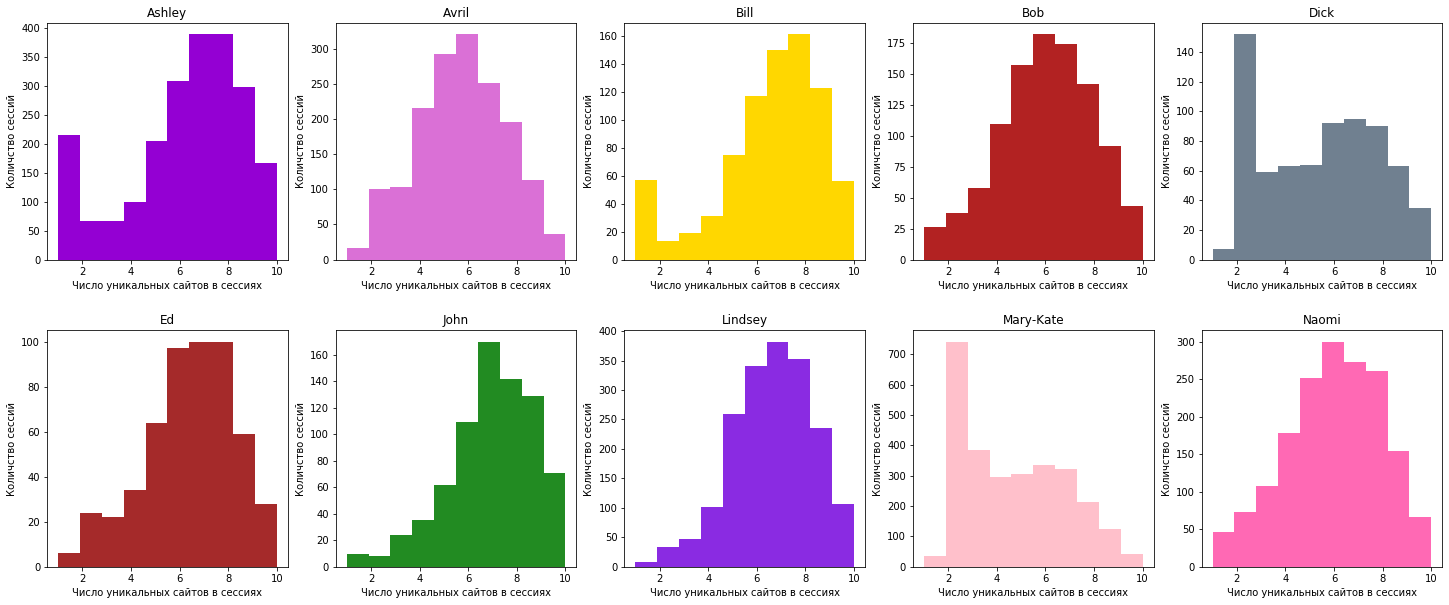

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for idx, (user, sub_df) in  enumerate(data_10users.groupby(['target'])):
    axes[idx // 5, idx % 5].hist(sub_df['#unique_sites'], color=color_dic[user])
    axes[idx // 5, idx % 5].set_xlabel('Число уникальных сайтов в сессиях')
    axes[idx // 5, idx % 5].set_ylabel('Количство сессий')
    axes[idx // 5, idx % 5].set_title(user)
plt.subplots_adjust(hspace=0.3)
plt.show()

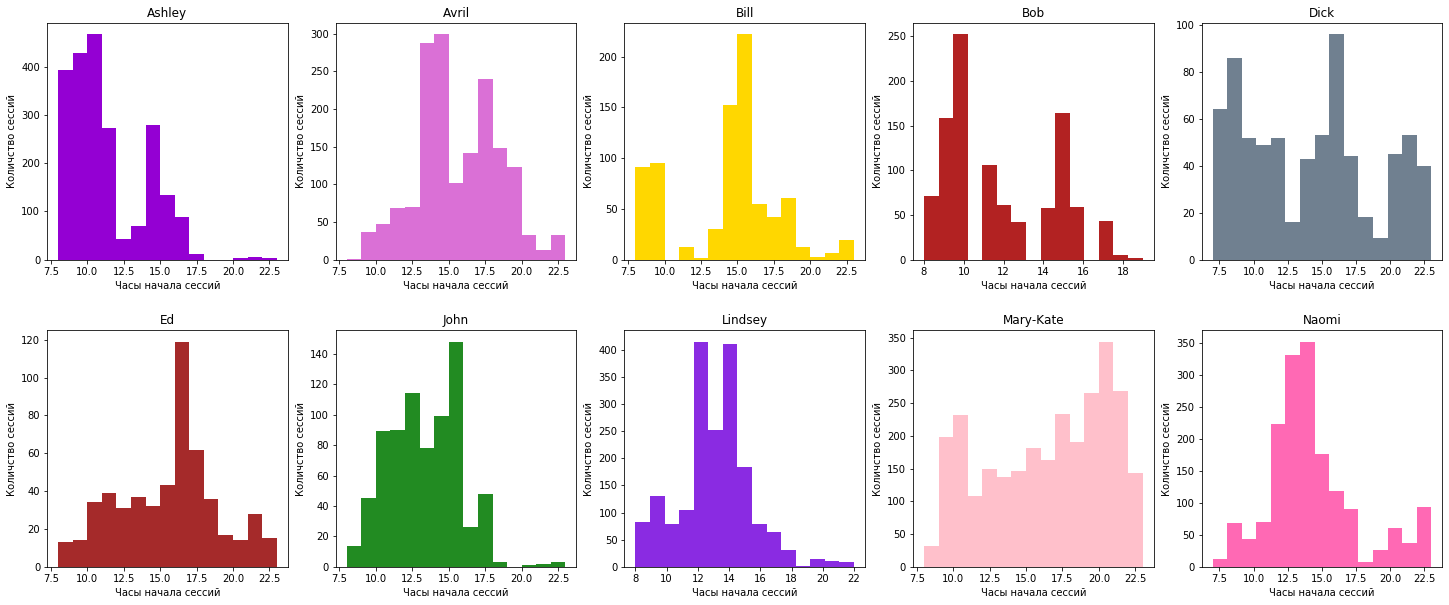

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for idx, (user, sub_df) in  enumerate(data_10users.groupby(['target'])):
    axes[idx // 5, idx % 5].hist(sub_df['start_hour'], color=color_dic[user], bins=15)
    axes[idx // 5, idx % 5].set_xlabel('Часы начала сессий')
    axes[idx // 5, idx % 5].set_ylabel('Количство сессий')
    axes[idx // 5, idx % 5].set_title(user)
plt.subplots_adjust(hspace=0.3)
plt.show()

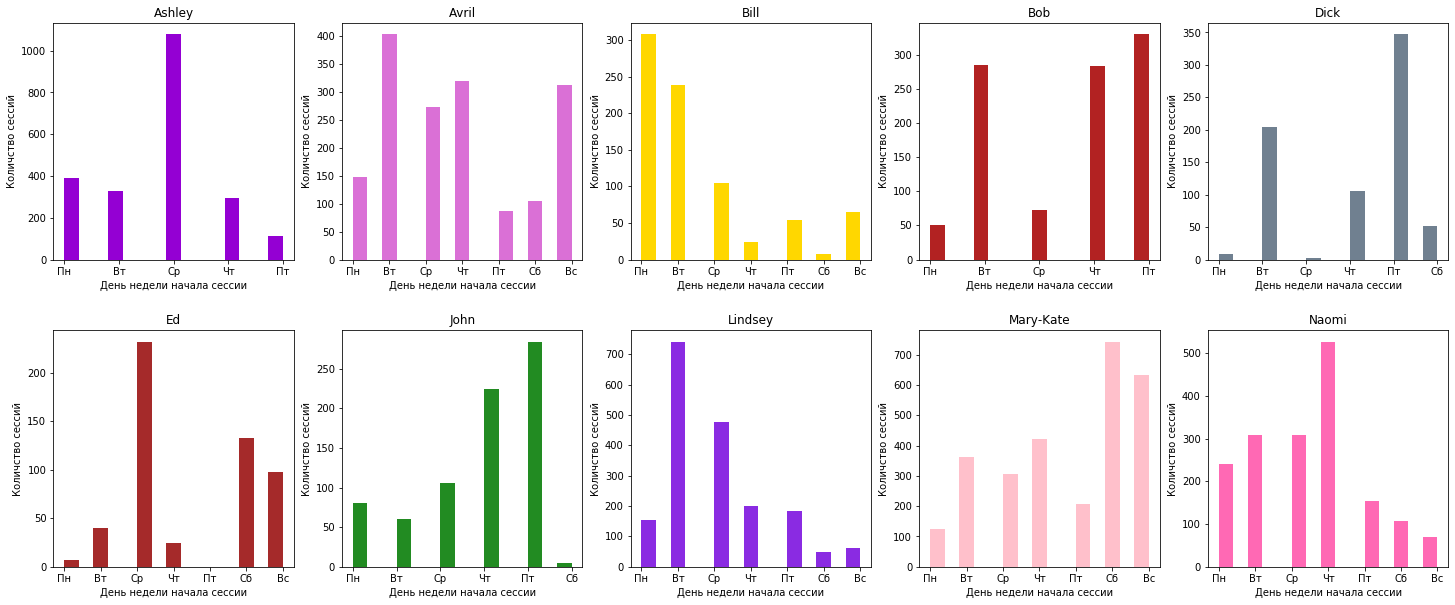

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for idx, (user, sub_df) in  enumerate(data_10users.groupby(['target'])):
    axes[idx // 5, idx % 5].hist(sub_df['day_of_week'], color=color_dic[user], bins=15)
    axes[idx // 5, idx % 5].set_xlabel('День недели начала сессии')
    axes[idx // 5, idx % 5].set_ylabel('Количство сессий')
    axes[idx // 5, idx % 5].set_title(user)
    
    axes[idx // 5, idx % 5].set_xticklabels(['', 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.subplots_adjust(hspace=0.3)
plt.show()

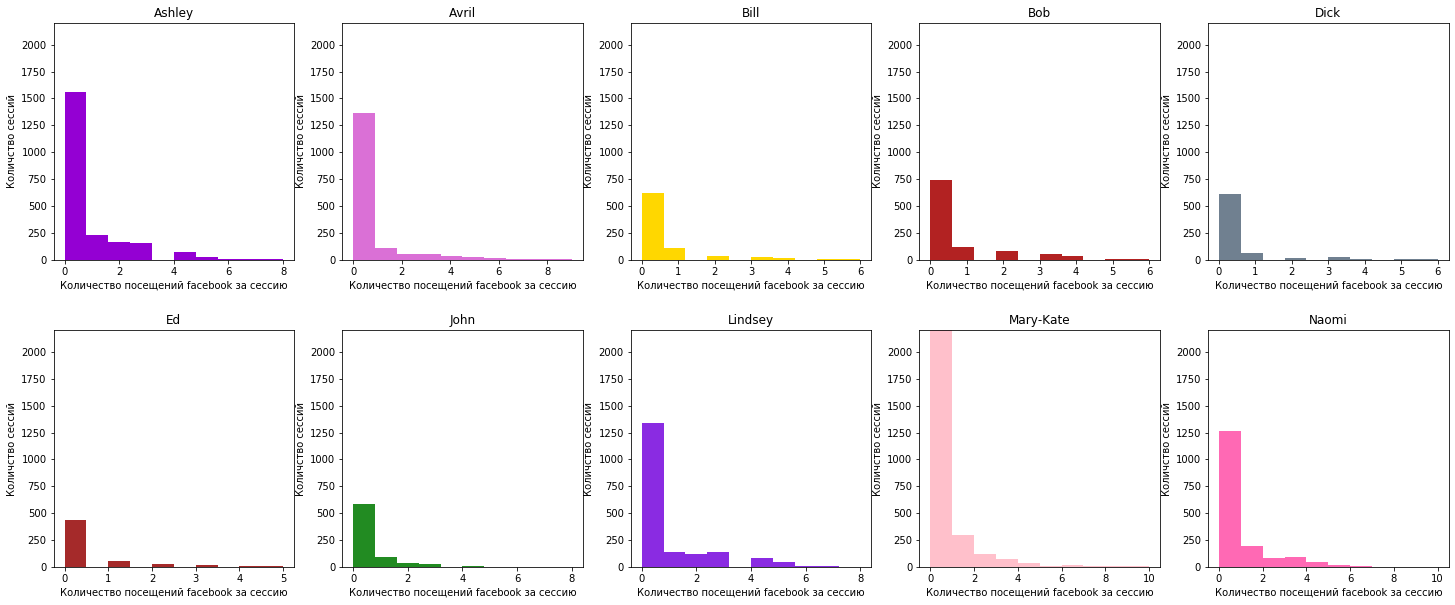

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for idx, (user, sub_df) in  enumerate(data_10users.groupby(['target'])):
    axes[idx // 5, idx % 5].set_ylim(0, 2200) ## для сравнения с facebook
    axes[idx // 5, idx % 5].hist(sub_df['facebook'], color=color_dic[user], bins=10)
    axes[idx // 5, idx % 5].set_xlabel('Количество посещений facebook за сессию')
    axes[idx // 5, idx % 5].set_ylabel('Количство сессий')
    axes[idx // 5, idx % 5].set_title(user)
plt.subplots_adjust(hspace=0.3)
plt.show()

**По всем гистограммам можно указать на некоторые общие моменты:** \
1) в среднем пик количества уникальных сайтов в сессии равно 6-7 \
2) в среднем активнее всего посещают сайты днем в районе 14:00, чуть меньше утром, а к вечеру активность падает \
3) в среднем активнее всего посеают сайты в среду по общей гистограмме, но если смотреть на каждого польщователя по отдельности, то это не так \
4) Про посещение facebook можно сказать, что чаще всего посещают несколько раз за сессию, возможно потому что либо не заходят, либо изредка проверить что-то или ответить кому-то. Мало кто сиди без остановки на одном таком сайте, точнее такое происходит редко.

**1)Ashley** \
Тяжелый левый хвост в гистограмме количеста уникальных сайтов (много сессий с одним сайтом). Возможно проверяет почту или сидив в сотсетях. \
Данный пользователь больше всего находится в сети утром до полудня, вечером - меньше всего. Похоже, что днем работает, а вечером отдыхает. \
Большая активность в Среду. Возможно это связанно с разгузочным днем или с конкретной работой.
  
**2)Avril** \
Очень типовое распределение количества уникальных сайтов. \
Активность появляется после часа дня, возможно после учебы. Далее есть просадка с 15:00 до 17:00. Возможно в этот период данный пользователь едет домой. \
По дням недели активность примерно равномерная с небольшими искажениями во вторник. А вот в пт и вс меньше всего активность, возможно в этот период преобладает активный отдых.

**3)Bill** \
Так же типовое распределение количества уникальных сайтов, только есть левый хвост, возможно связанный с посещением соцсетей. \
Можно отметить, что утром есть активность, возможно проверка почты, прогноза погоды, новостей и тд. Далее активность падает, но в районе двух часов дня появляется пиковая активность. Возможно это связанно с перерывом на работе. Далее активность падает \
Больше всего посещение в начале недели и постепенно падает. Возможно связанно с дэдлайнами на конец рабочей недели и с активным отдыхов в выходные 

**4)Bob** \
Распределение количества уникальных сайтов абсолютно типовое. \
Распределение начал сессий тоже типовое, все такие же пики в среднем. \
А вот активность по дням недели отличаются. По выходным больше всего посещений сайтов. Возможно пользователь не любит активный отдых или что-то вроде этого в данный период.

**5)Dick** \
Данный пользователь по  сравнению с остальными особо не сидит в сети, так как максимально кол-ва сайтов меньше на всех гистограммах. Активнее всего проверяются одни и те же сайты, а дальше примерно все равномерно. \
Активность можно наблюдать на протяжении всего активного дня. Свойственны типовые пики, вторые выше были обозначены для всех пользователей\
Больше всего сидит в сети в Пт. Сложно сказать, с чем это может быть связано, вариантов слишком много.

**6)Ed** \
Распределение количества уникальных сайтов абсолютно типовое.  \
Данный пользователь сидит в сети меньше всех, даже меньше чем Dick. Пик ближе к вечеру. Возможно возвращается на общественном транспорте домой и сидит в сети от скуки. \
Активность выше в среду и в выходные.

**7)John** \
Распределение количества уникальных сайтов скошено немного вправо. Возможно делает много запросов в поисковике, связанное с работой. \
Активнее всего до 18:00. Возможно работа связанна с активным использованием интернета. \
По дням недели выражена повышение активности к выходным. Затрудняюсь ответить на то, с чем это связанно.

**8)Lindsey** \
Распределение количества уникальных сайтов скошено немного вправо. Возможно делает много запросов в поисковике, связанное с работой. \
Активнее всего до 18:00. Возможно работа связанна с активным использованием интернета, но пики приходятся на отрезки 12-13 и 14-15. Возможно в эти периоды перерыв. \
Со вторника активность в сети падает, а в выходные меньше всего

**9)Mary-Kate** \
Распределение количества уникальных сайтов похоже на распределение Dick’а. \
По времени начала сессий можно сказать, что пользователь примерно равномерно пользуется сетью, но есть пики утром и вечером. \
Можно выбелить большое использование интернета в выходные.

**10)Naom** \
Распределение количества уникальных сайтов абсолютно типовое. \
Распределение часов активности похоже на распределение Avril’а. \
В будни активность примерно равномерная, но в четверг выше среднего, а в пятницу - падает. В выходные меньше всего


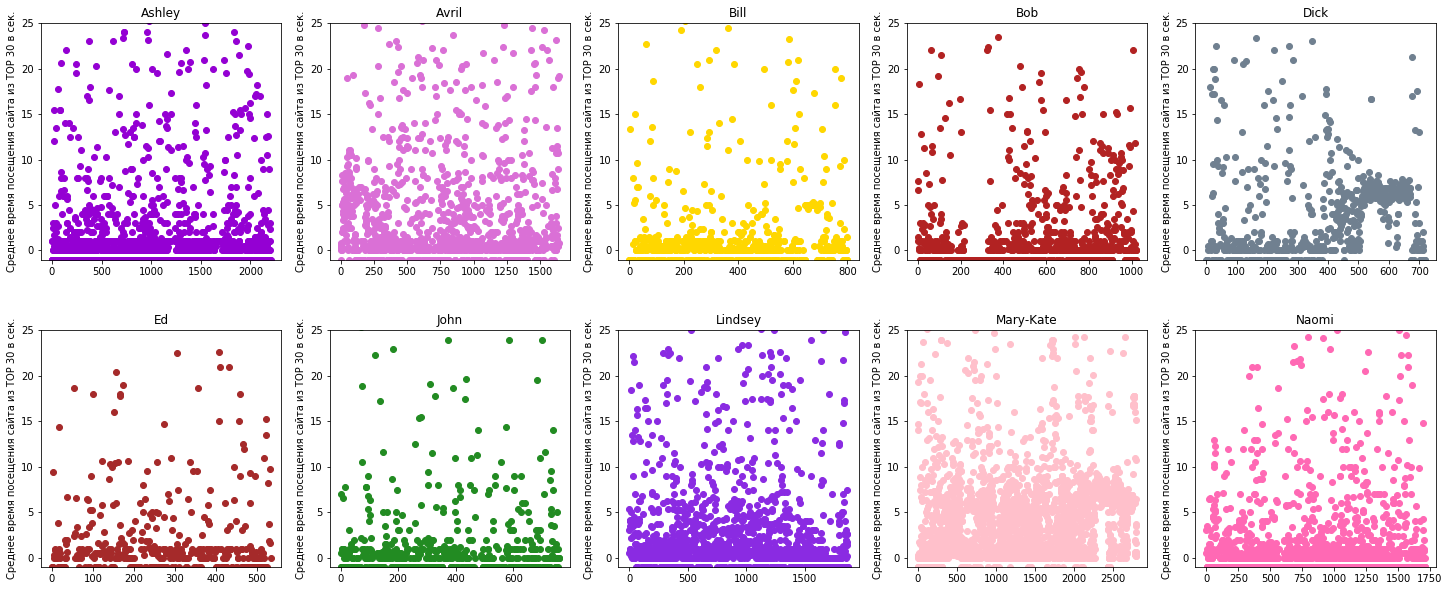

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for idx, (user, sub_df) in  enumerate(data_10users.groupby(['target'])):
    axes[idx // 5, idx % 5].set_ylim(-1, 25)
    axes[idx // 5, idx % 5].scatter(y=sub_df['Average_time_on_top30_sites'],
                                    x=np.arange(len(sub_df['Average_time_on_top30_sites'])),
                                    color=color_dic[user])
    axes[idx // 5, idx % 5].set_ylabel('Среднее время посещения сайта из TOP 30 в сек.')
    axes[idx // 5, idx % 5].set_title(user)
plt.subplots_adjust(hspace=0.3)
plt.show()

Результаты выведены таким образом специально, потому что смотреть все неудобно из-за больших выбросов (например, просмотр видео на ютубе) нижняя часть сильно слепливается  в линию. Можно отметить, что у Ashley, Lindsey и Bill очень много посещений сайтов за меньше чем за одну секунду. Это важной момент. 
Mary-Kate ведет себя не так как все. Значение данной величины примерно до 10, но эта область очень плотная. А вот у оставшихся посещение сайтов достаточно долгое, т.к. плотность точек маленькая, даже в районе нуля (в сравнением с остальными)

# III Построение моделей

In [23]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)  

X_train, X_valid, y_train, y_valid = train_test_split(X, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [90]:
%%time
models = {'k Nearest Neighbors': {'model': KNeighborsClassifier(n_jobs=-1, n_neighbors=100),
                 'param': 'n_neighbors',
                 'range': [1, 3, 5, 10, 50, 100]}, 
         'Random Forest': {'model': RandomForestClassifier(random_state=17, n_jobs=-1),
                   'param': 'n_estimators',
                    'range': [5, 10, 50, 100]},
         'Logistic Regression': {'model': LogisticRegression(random_state=17, n_jobs=-1),
                  'param': 'C',
                  'range': np.logspace(-4, 2, 10)}}

cv_holdouts = dict()

for algorithm in models:
    model = models[algorithm]['model']
    param = models[algorithm]['param']
    rng = models[algorithm]['range']
    
    grid = {param : rng}
    gs = GridSearchCV(estimator=model, param_grid=grid, cv=skf, scoring='accuracy', n_jobs=-1 )
    gs.fit(X_train, y_train)
    cv_score = gs.best_score_
    acc_score = accuracy_score(y_valid, gs.predict(X_valid))
    cv_holdouts[algorithm] = (cv_score, acc_score)

scores = pd.DataFrame(list(cv_holdouts.values()),index=[name for name in cv_holdouts],
             columns=['CV score','Hold out Score'])
best_model = scores.index[scores['Hold out Score'].argmax()]
print('Best score -', np.round(scores.loc[best_model, 'Hold out Score'], 3))
print('Model -', best_model)

Best score - 0.694
Model - Logistic Regression
CPU times: user 22.3 s, sys: 1.58 s, total: 23.9 s
Wall time: 1min 50s


Best parameter - {'C': 1.0}


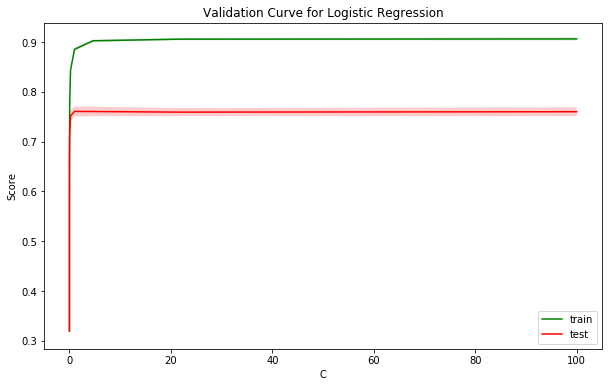

In [96]:
gs = GridSearchCV(estimator=models[best_model]['model'],
                  param_grid={models[best_model]['param'] : models[best_model]['range']},
                  cv=skf, scoring='accuracy', n_jobs=-1, 
                  return_train_score=True)
gs.fit(X_train, y_train)
plt.figure(figsize=(10,6))
plot_validation_curves(models[best_model]['range'], gs.cv_results_)
plt.title('Validation Curve for {}'.format(best_model))
plt.xlabel('C')
plt.ylabel('Score');
print('Best parameter - {}'.format(gs.best_params_))

In [109]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    start_time = time()
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                          test_size=test_size, 
                                                          random_state=random_state, stratify=y)
    estimator.fit(X_train, y_train)
    CV_accuracy = cross_val_score(estimator, X_train, y_train, cv=cv).mean()
    accuracy = estimator.score(X_valid, y_valid)
    total_time = round(time() - start_time, 4)
    
    return CV_accuracy, accuracy, total_time


start_time = time()
estimator = gs.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        X_name = ('X_sparse_10users_s' + str(session_length) + '_w' + str(window_size) + '.pkl')
        y_name = ('y_10users_s'        + str(session_length) + '_w' + str(window_size) + '.pkl')
        path_to_X_pkl = os.path.join('data_w2', X_name)
        path_to_y_pkl = os.path.join('data_w2', y_name)
        
        res = model_assessment(gs.best_estimator_, 
                               path_to_X_pkl, path_to_y_pkl,
                               skf, random_state=17, test_size=0.3)
        
        print('w =', window_size, 's =', session_length, ':', res[0], res[1], 'total_time = ', res[2])

print()
print('Wall time:', time() - start_time)

w = 10 s = 15 : 0.8210739091542089 0.839772457928419 total_time =  9.7051
w = 10 s = 10 : 0.7606189739891912 0.7767243422611994 total_time =  9.3182
w = 7 s = 15 : 0.8480089785002685 0.8543222166915547 total_time =  10.3411
w = 7 s = 10 : 0.7990045385748815 0.8065372490459598 total_time =  11.3723
w = 7 s = 7 : 0.7491466591073834 0.755433880869421 total_time =  9.9065
w = 5 s = 15 : 0.8641904289699047 0.872569938359412 total_time =  12.7214
w = 5 s = 10 : 0.8166850293617248 0.827524893314367 total_time =  12.7162
w = 5 s = 7 : 0.7677063623059642 0.7861545756282599 total_time =  12.4115
w = 5 s = 5 : 0.7223857826426915 0.73316737790422 total_time =  11.6851

Wall time: 100.19635009765625


Из рассмотренных комбинаций окна и длины сессии для 10 пользователей лучший результат получен при w = 5 s = 15, но для 150 пользователей был получен лучший результат при w = 10 s = 10

# IV Тестирование

In [112]:
%%time
with open(os.path.join('data_w2', 
         'X_sparse_150users_s10_w10.pkl'), 'rb') as inf:
    X_sparse_150users = pickle.load(inf)
with open(os.path.join('data_w2', 
                       'y_150users_s10_w10.pkl'), 'rb') as inf:
    y_150users = pickle.load(inf)  

X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_150users, y_150users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

logit_cv_150users = LogisticRegressionCV(random_state=17, n_jobs=-1, multi_class='ovr', Cs=[1])
logit_cv_150users.fit(X_train, y_train)

CPU times: user 8min 57s, sys: 15.3 s, total: 9min 12s
Wall time: 19min 10s


LogisticRegressionCV(Cs=[1], class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
                     random_state=17, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

In [113]:
class_distr = (y_train.shape[0] - np.bincount(y_train.astype('int')))/y_train.shape[0]

for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, np.round(logit_cv_150users.scores_[user_id].mean(), 3)))

User 6, CV score: 0.996
User 13, CV score: 0.996
User 15, CV score: 0.995
User 16, CV score: 0.992
User 28, CV score: 0.99
User 31, CV score: 0.994
User 33, CV score: 0.994
User 39, CV score: 0.986
User 46, CV score: 0.998
User 49, CV score: 0.995
User 50, CV score: 0.995
User 53, CV score: 0.994
User 65, CV score: 0.997
User 66, CV score: 0.995
User 82, CV score: 0.996
User 85, CV score: 0.996
User 89, CV score: 0.991
User 92, CV score: 0.994
User 100, CV score: 0.995
User 102, CV score: 0.991
User 103, CV score: 0.981
User 105, CV score: 0.997
User 106, CV score: 0.995
User 118, CV score: 0.991
User 119, CV score: 0.997
User 120, CV score: 0.994
User 126, CV score: 0.995
User 127, CV score: 0.992
User 128, CV score: 0.985
User 138, CV score: 0.997
User 158, CV score: 0.997
User 160, CV score: 0.997
User 165, CV score: 0.997
User 172, CV score: 0.997
User 177, CV score: 0.997
User 203, CV score: 0.998
User 207, CV score: 0.988
User 223, CV score: 0.997
User 233, CV score: 0.996
User 2

In [114]:
class_distr = (y_train.shape[0] - np.bincount(y_train.astype('int')))/y_train.shape[0]


acc_diff_vs_constant = []
for user_id in np.unique(y_train):
    acc_diff_vs_constant.append(logit_cv_150users.scores_[user_id].mean() - class_distr[user_id])
    
num_better_than_default = ((np.array(acc_diff_vs_constant)) > 0).sum()
print('Доля классов, которые алгоритм определяет лучше константного прогноза: %i %' % (num_better_than_default/150 * 100))

Доля классов, которые алгоритм определяет лучше константного прогноза: 90 процентов


In [115]:
y_binary_128 = (y_train == 128).astype(int)

from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

Покажем, что увеличение количества пользователей не нужно

In [126]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
n_train, val_train, val_test = learning_curve(estimator=estimator, 
                                             X=X_train, y=y_binary_128, train_sizes=train_sizes,
                                             cv=skf, scoring='accuracy', verbose=1, random_state=17, n_jobs=-1)

[learning_curve] Training set sizes: [15985 18509 21033 23557 26081 28605 31129 33653 36177 38701 41225 43749
 46273 48797 51321 53845 56369 58893 61417 63942]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 405 ms, sys: 320 ms, total: 725 ms
Wall time: 8.81 s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.7s finished


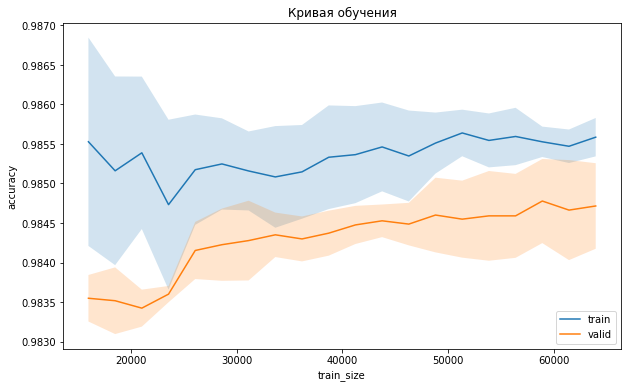

In [117]:
plt.figure(figsize=(10,6))
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')
plt.title('Кривая обучения');

Можно видеть, что точность не очень медленно растет, поэтому можно ограничиться этим числом.

# V Выводы

Модель дает адекватное качество при отличии одного пользователя от другого. Ее можно примернять, как было выше сказано, для идентификации влома аккаутов. Но для этого надо иметь историю запросов клиента. Так же есть недочет в дальнейшем обучении модели. Мы сделали расчеты на ограниченном количестве пользователей, а на огромном мне пока сложно предугадать результат точности. Помимо этого мы упремля во время работы самой модели, потому что злоумышленник может сделать свои плохие дела, а модель отреагирует только после какого-то времени.